# Import

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs

# Facebook Prophet model
from fbprophet import Prophet

# RNN - LSTM 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# To avoid warning messages
import warnings
warnings.filterwarnings("ignore")

# Evaluation table
val_df = pd.DataFrame({"Model":[], "RMSE":[],"MAPE":[]})

Importing plotly failed. Interactive plots will not work.


# Bitcoin dataset

In [2]:
# Bitcoin dataset 2021-02-16/2022-02-16
df = pd.read_csv("../Downloads/BTC-USD.csv", parse_dates=['Date'], index_col=["Date"])

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,47944.457031,50341.101563,47201.304688,49199.871094,49199.871094,77049582886
2021-02-17,49207.277344,52533.914063,49072.378906,52149.007813,52149.007813,80820545404
2021-02-18,52140.972656,52474.105469,51015.765625,51679.796875,51679.796875,52054723579
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132813,55888.132813,63495496918
2021-02-20,55887.335938,57505.226563,54626.558594,56099.519531,56099.519531,68145460026
...,...,...,...,...,...,...
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,42244.468750,18152390304
2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,42197.515625,14741589015
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,42586.917969,20827783012


In [4]:
df.shape

(366, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2021-02-16 to 2022-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       366 non-null    float64
 1   High       366 non-null    float64
 2   Low        366 non-null    float64
 3   Close      366 non-null    float64
 4   Adj Close  366 non-null    float64
 5   Volume     366 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


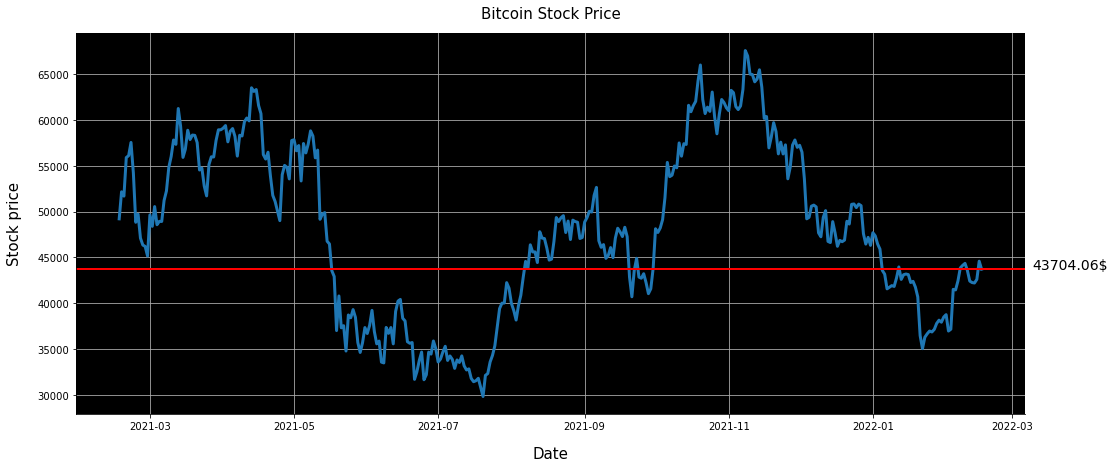

In [6]:
# Plotting "Close" values in the observing timespan

fig, ax = plt.subplots()

fig.set_size_inches(17,7)

ax.plot(df.index, df.Close, label="Bitcoin Stock Price", linewidth=3)
ax.set_title("Bitcoin Stock Price",fontsize=15, pad=15)
ax.set_xlabel("Date", fontsize=15, labelpad=15)
ax.set_ylabel("Stock price", fontsize=15, labelpad=15)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid()

ax.annotate('%0.2f' % df.Close[-1]+"$", xy=(1, df.Close[-1]), xytext=(8,0), 
            xycoords=('axes fraction', 'data'), textcoords="offset points",  fontsize=14)


ax.axhline(y=43704.06, linewidth=2, color='r')
ax.set_facecolor('black')

plt.show()

# Forecasting

## ARIMA

In [7]:
# Set our target table for the observations
data = df["Close"]

### Decomposing 

To have an insight about the time-series' trend, seasonality and noise component.

In [8]:
decomp = seasonal_decompose(data, model="multplicative", period=30)

In [9]:
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

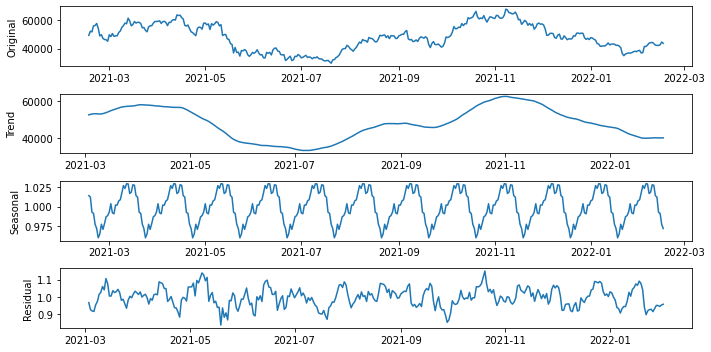

In [10]:
plt.figure(figsize=(10,5))

plt.title("Timeseries components")
plt.subplot(411)
plt.plot(data)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(resid)
plt.ylabel('Residual')

plt.tight_layout()


### Stationarity 

Constant mean and variance, no trend and seasonality what makes a time-series stationary.

An easy way to find out if a timeseries is stationary to make the Augmented Dickey-Fuller test.  
If the p-value < 0,05 then it means the time series is stationary, above that value it indicates non-stationarity.

In [11]:
# ADFuller test

print("ADF stat:", adfuller(data)[0])
print("p-value:", adfuller(data)[1])
for key, value in adfuller(data)[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF stat: -1.866624253299354
p-value: 0.3479212629484274
Critial Values:
   1%, -3.4483935212959844
Critial Values:
   5%, -2.8694912343676497
Critial Values:
   10%, -2.571005879151811


In [12]:
# Checking d, the number of the differencing the time series need to be stationary for the ARIMA model 
# d = 1
ndiffs(data, test="adf")

1

In [13]:
# Differencing
diff = data.diff().dropna()

In [14]:
print("ADF stat:", adfuller(diff)[0])
print("p-value:", adfuller(diff)[1])
for key, value in adfuller(diff)[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF stat: -19.988489725177427
p-value: 0.0
Critial Values:
   1%, -3.4484434475193777
Critial Values:
   5%, -2.869513170510808
Critial Values:
   10%, -2.571017574266393


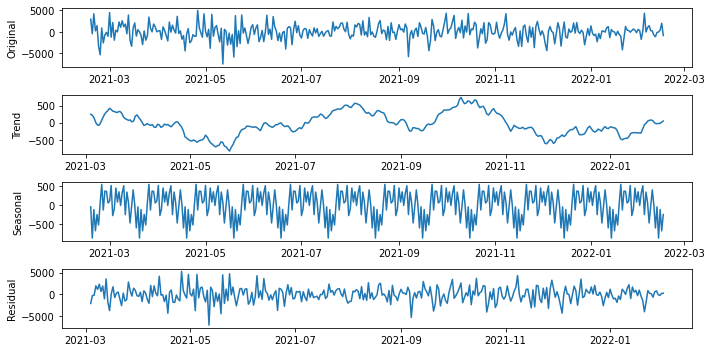

In [15]:
## Plotting the components after differencing

decomp1 = seasonal_decompose(diff, model="additive", period=30)

trend1 = decomp1.trend
seasonal1 = decomp1.seasonal
resid1 = decomp1.resid


plt.figure(figsize=(10,5))

plt.title("Timeseries components after differencing")
plt.subplot(411)
plt.plot(diff)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend1)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal1)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(resid1)
plt.ylabel('Residual')

plt.tight_layout()

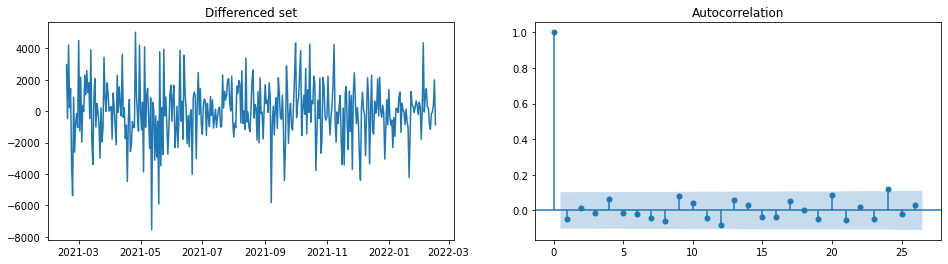

In [16]:
# The time series after differencing and the ACF plot
# From the PACF plot we can also assume the order of q, Moving Average(MA) term 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced set")
plot_acf(diff, ax=ax2);

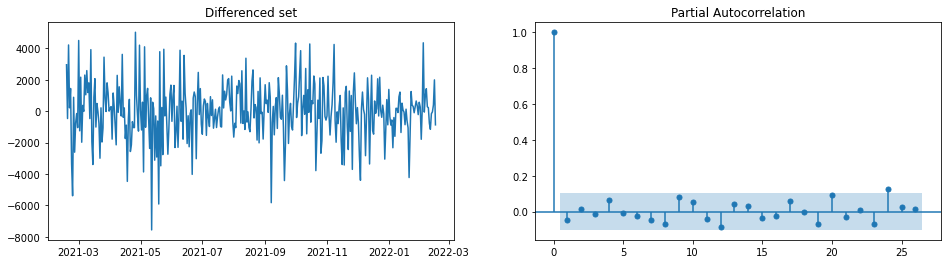

In [17]:
# The differenced plot with the PACF plot
# From the PACF plot we can also assume the order of p, Autoregression(AR) term 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced set")
plot_pacf(diff, ax=ax2);

Since the values are not above the significant line on the plots, hence according to the correlation plots we can not determine confidently the order of p and q.

### Finding the orders of ARIMA with for loop

In [18]:
import itertools

p = range(0,6)
d = range(0,2)
q = range(0,6)

pdq_comb = list(itertools.product(p,d,q))

In [19]:
len(pdq_comb)

72

In [20]:
from tqdm import tqdm

orders = []
rmse = []

for pdq in tqdm(pdq_comb):
    try:
        model = ARIMA(train, order=(pdq)).fit()
        pred = model.predict(start=len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test, pred))

        orders.append(pdq)
        rmse.append(error)
        
    except:
        continue
    

100%|███████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 71493.82it/s]


In [21]:
odf = pd.DataFrame(index=orders, data=rmse, columns=["RMSE"])

In [22]:
odf.sort_values(by="RMSE").head()

,RMSE


### ARIMA model

Eventough ARIMA is an autoregressive model and can not handle seasonality, but weak stationarity is enough to the model to process the data. 

In [23]:
## Setting up our model, p=3, d=0, q=3.

train = data[:257]
test = data[257:]

model = ARIMA(train, order=(3,0,3)).fit(disp=0)

pred = model.predict(start=len(train), end=(len(data)-1))

### Evaluation - RMSE, MAPE

In [24]:
# Root mean squared error
rmse = np.sqrt(mean_squared_error(test, pred))

In [25]:
# Mean absolute percentage error
mape = round(mean_absolute_percentage_error(test, pred), 3)

In [26]:
rmse

3161.1149120374434

In [27]:
mape

0.053

In [28]:
val_df.loc[0] = ['ARIMA', rmse, mape]

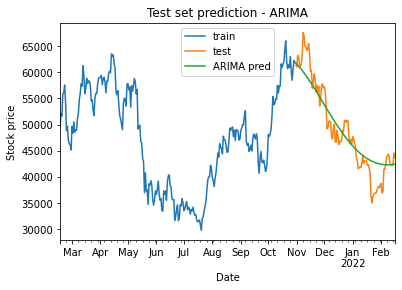

In [29]:
# Plotting the prediction results on the test set
plt.title("Test set prediction - ARIMA")

train.plot(legend=True, label="train")
test.plot(legend=True, label="test")
pred.plot(legend=True, label="ARIMA pred")

plt.xlabel("Date")
plt.ylabel("Stock price")

plt.show()

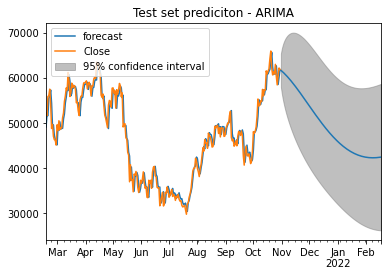

In [30]:
# Model forecast with 95% confidence interval
model.plot_predict(1, (len(df)), dynamic=False);

plt.title("Test set prediciton - ARIMA")
plt.legend(loc=2)

plt.show()

In [31]:
# Model summary about the orders and results
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  257
Model:                     ARMA(3, 3)   Log Likelihood               -2305.935
Method:                       css-mle   S.D. of innovations           1890.990
Date:                Thu, 03 Mar 2022   AIC                           4627.871
Time:                        15:48:20   BIC                           4656.263
Sample:                    02-16-2021   HQIC                          4639.289
                         - 10-30-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.744e+04   2014.855     23.547      0.000    4.35e+04    5.14e+04
ar.L1.Close     0.9801      0.015     65.815      0.000       0.951       1.009
ar.L2.Close     0.9991      0.021     47.835    

### Forecast

In [32]:
## Using the whole dataset to make the prediction
final_model = ARIMA(data, order=(3,0,3)).fit(disp=0)

final_pred = final_model.predict(start=len(data), end=(len(data)+100))

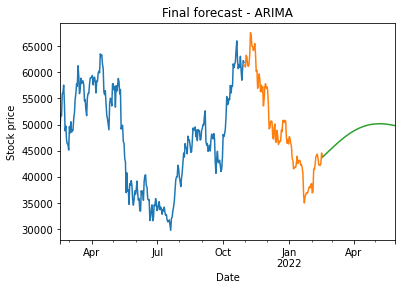

In [33]:
plt.title("Final forecast - ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock price")

train.plot()
test.plot()
final_pred.plot()

plt.show()

In [34]:
final_pred

2022-02-17    43882.588450
2022-02-18    44012.589030
2022-02-19    44139.418879
2022-02-20    44270.612206
2022-02-21    44398.401843
                  ...     
2022-05-24    49920.227402
2022-05-25    49895.973402
2022-05-26    49866.829867
2022-05-27    49840.483667
2022-05-28    49809.334461
Freq: D, Length: 101, dtype: float64

## Prophet

### Preprocessing 

The model accepts only "ds" and "y" input values as a feature and target.

In [35]:
df_prophet = df.reset_index()

In [36]:
df_prophet = df_prophet[["Date","Close"]]

In [37]:
len(df_prophet)

366

In [38]:
df_p = df_prophet.rename(columns={"Date":"ds","Close":"y"})

In [39]:
train_p = df_p[:257]
test_p = df_p[257:]

### Model 

In [40]:
# Prophet is able to capture daily, weekly, yearly seasonality.
model = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=True)

In [41]:
train_p

,ds,y
0,2021-02-16,49199.871094
1,2021-02-17,52149.007813
2,2021-02-18,51679.796875
3,2021-02-19,55888.132813
4,2021-02-20,56099.519531
...,...,...
252,2021-10-26,60363.792969
253,2021-10-27,58482.386719
254,2021-10-28,60622.136719
255,2021-10-29,62227.964844


In [42]:
model.fit(train_p)

In [43]:
test_future = model.make_future_dataframe(periods=len(test_p))

In [44]:
pred_p = model.predict(test_future)

In [45]:
test_future

,ds
0,2021-02-16
1,2021-02-17
2,2021-02-18
3,2021-02-19
4,2021-02-20
...,...
361,2022-02-12
362,2022-02-13
363,2022-02-14
364,2022-02-15


In [46]:
pred_p

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-16,48308.415266,49119.962745,59340.522047,48308.415266,48308.415266,6169.911923,6169.911923,6169.911923,-3413.799524,...,-425.929737,-425.929737,-425.929737,10009.641184,10009.641184,10009.641184,0.0,0.0,0.0,54478.327189
1,2021-02-17,48341.962895,48649.756892,58180.155914,48341.962895,48341.962895,5326.388410,5326.388410,5326.388410,-3413.799524,...,-80.918140,-80.918140,-80.918140,8821.106074,8821.106074,8821.106074,0.0,0.0,0.0,53668.351305
2,2021-02-18,48375.510525,47207.265346,57384.772015,48375.510525,48375.510525,4143.729840,4143.729840,4143.729840,-3413.799524,...,-208.118915,-208.118915,-208.118915,7765.648278,7765.648278,7765.648278,0.0,0.0,0.0,52519.240364
3,2021-02-19,48409.058154,47338.946239,57318.433838,48409.058154,48409.058154,3690.192441,3690.192441,3690.192441,-3413.799524,...,255.925504,255.925504,255.925504,6848.066462,6848.066462,6848.066462,0.0,0.0,0.0,52099.250595
4,2021-02-20,48442.605783,46416.206500,56110.139311,48442.605783,48442.605783,2914.066595,2914.066595,2914.066595,-3413.799524,...,257.512289,257.512289,257.512289,6070.353830,6070.353830,6070.353830,0.0,0.0,0.0,51356.672378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2022-02-12,60791.681959,69065.354147,78759.289559,60753.890005,60830.872584,13152.776551,13152.776551,13152.776551,-3413.799524,...,257.512289,257.512289,257.512289,16309.063786,16309.063786,16309.063786,0.0,0.0,0.0,73944.458510
362,2022-02-13,60826.849467,67259.628167,76631.927687,60788.545827,60866.501587,11439.905944,11439.905944,11439.905944,-3413.799524,...,176.183753,176.183753,176.183753,14677.521716,14677.521716,14677.521716,0.0,0.0,0.0,72266.755411
363,2022-02-14,60862.016976,65631.808385,75428.658824,60823.200409,60902.130590,9737.027582,9737.027582,9737.027582,-3413.799524,...,25.345246,25.345246,25.345246,13125.481860,13125.481860,13125.481860,0.0,0.0,0.0,70599.044557
364,2022-02-15,60897.184484,63753.620072,74038.751821,60857.855110,60937.736212,7830.652998,7830.652998,7830.652998,-3413.799524,...,-425.929737,-425.929737,-425.929737,11670.382258,11670.382258,11670.382258,0.0,0.0,0.0,68727.837481


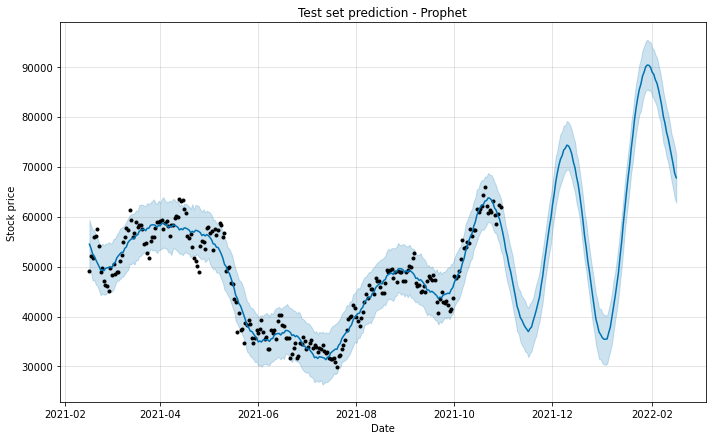

In [47]:
model.plot(pred_p);
plt.title("Test set prediction - Prophet")
plt.ylabel("Stock price")
plt.xlabel("Date")

plt.show()

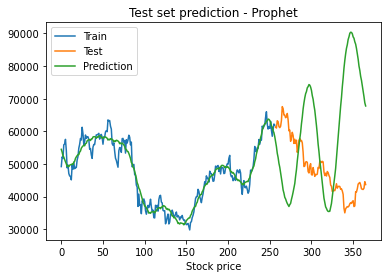

In [48]:
# Comparing the real values with the predicition

plt.plot(train_p["y"], label="Train")
plt.plot(test_p["y"],label="Test")
plt.plot(pred_p["yhat"], label="Prediction")

plt.title("Test set prediction - Prophet")
plt.xlabel("Date")
plt.xlabel("Stock price")

plt.legend()

plt.show()

### Evaluation - RMSE, MAPE

In [49]:
y_pred = pred_p["yhat"][257:]

In [50]:
rmse_p = np.sqrt(mean_squared_error(test_p["y"], y_pred))

In [51]:
mape_p = mean_absolute_percentage_error(test_p["y"], y_pred)

In [52]:
rmse_p

26102.748390907473

In [53]:
mape_p

0.47988129597906504

In [54]:
val_df.loc[1] = ['Prophet', rmse_p, mape_p]

### Forecast

In [55]:
model = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=True)
model.fit(df_p)

final_fut = model.make_future_dataframe(periods=100)

final_pred_p = model.predict(final_fut)

In [56]:
final_pred_p

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-16,49723.281141,46534.746025,55812.895148,49723.281141,49723.281141,1444.012854,1444.012854,1444.012854,2182.077762,...,-82.891796,-82.891796,-82.891796,-655.173113,-655.173113,-655.173113,0.0,0.0,0.0,51167.293995
1,2021-02-17,49701.573117,46144.524343,56088.167523,49701.573117,49701.573117,1595.616276,1595.616276,1595.616276,2182.077762,...,50.407918,50.407918,50.407918,-636.869405,-636.869405,-636.869405,0.0,0.0,0.0,51297.189392
2,2021-02-18,49679.865092,46092.987686,55821.164597,49679.865092,49679.865092,1340.500800,1340.500800,1340.500800,2182.077762,...,-199.447989,-199.447989,-199.447989,-642.128973,-642.128973,-642.128973,0.0,0.0,0.0,51020.365892
3,2021-02-19,49658.157067,46552.481203,55636.339222,49658.157067,49658.157067,1460.689511,1460.689511,1460.689511,2182.077762,...,-55.194587,-55.194587,-55.194587,-666.193664,-666.193664,-666.193664,0.0,0.0,0.0,51118.846579
4,2021-02-20,49636.449043,46498.900737,55856.031925,49636.449043,49636.449043,1479.409524,1479.409524,1479.409524,2182.077762,...,1.183082,1.183082,1.183082,-703.851320,-703.851320,-703.851320,0.0,0.0,0.0,51115.858567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2022-05-23,39715.862008,27779.832828,37268.117342,39715.859687,39715.864096,-7193.950146,-7193.950146,-7193.950146,2182.077762,...,102.517387,102.517387,102.517387,-9478.545295,-9478.545295,-9478.545295,0.0,0.0,0.0,32521.911862
462,2022-05-24,39694.153908,26818.521228,36186.159068,39694.151556,39694.156025,-8129.737304,-8129.737304,-8129.737304,2182.077762,...,-82.891796,-82.891796,-82.891796,-10228.923270,-10228.923270,-10228.923270,0.0,0.0,0.0,31564.416604
463,2022-05-25,39672.445807,26241.289174,35575.703522,39672.443424,39672.447967,-8695.579648,-8695.579648,-8695.579648,2182.077762,...,50.407918,50.407918,50.407918,-10928.065329,-10928.065329,-10928.065329,0.0,0.0,0.0,30976.866159
464,2022-05-26,39650.737707,25490.584263,34958.871965,39650.735292,39650.739889,-9587.839689,-9587.839689,-9587.839689,2182.077762,...,-199.447989,-199.447989,-199.447989,-11570.469462,-11570.469462,-11570.469462,0.0,0.0,0.0,30062.898017


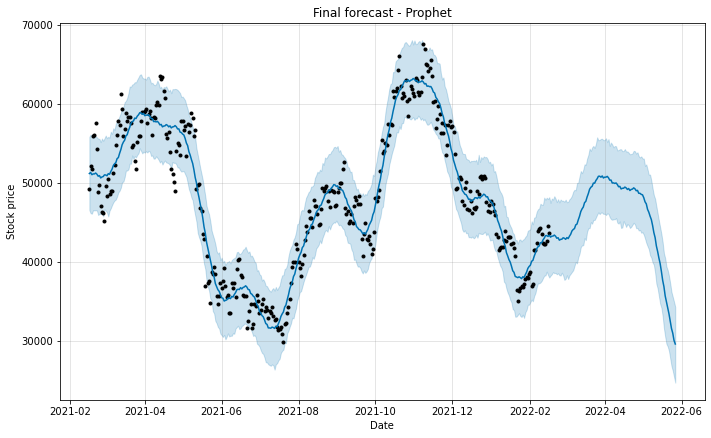

In [57]:
model.plot(final_pred_p);
plt.title("Final forecast - Prophet")
plt.ylabel("Stock price")
plt.xlabel("Date")

plt.show()

In [58]:
final_pred_p = final_pred_p[["ds","yhat"]][len(data):].set_index("ds")

In [59]:
final_pred_p = final_pred_p.reset_index()

In [60]:
final_pred_p = final_pred_p.rename(columns={"ds":"Date","yhat":"Close"})

In [61]:
final_pred_p = final_pred_p.set_index("Date")

## RNN - LSTM 

Long Short-Term Memory model is a type of Recurrent Neural Network, which is able to store recent values, evaluate and filter them with the gates and hidden layers in order to have proper prediction. 

### Scaling and preprocessing data

In [62]:
from sklearn.preprocessing import MinMaxScaler

To get the acceptable values for sigmoid(0,1) and hyperbolic tanget(-1,1) functions MinMaxScaler process our values between 0 and 1.

In [63]:
scaler = MinMaxScaler()

train1 = np.array(train).reshape(-1,1)
test1 = np.array(test).reshape(-1,1)
scaler.fit(train1)

MinMaxScaler()

In [64]:
train_scaled = scaler.transform(train1)
test_scaled = scaler.transform(test1)

LSTM model requires the input data in 3D form(batch/num of samples, num of timesteps, num of features), so first we have to convert our data.

In [65]:
# Creating training sets for fitting the model

# timestep = 25 had the best model evaluation
timestep = 25

X_train = []
y_train = []

# the timestep will determine the loop range, each batch will contain timestep number of values
# with these number of values will the model predict the next value
for i in range(timestep, len(train)-timestep):
    X_train.append(train_scaled[i-timestep:i, 0])
    y_train.append(train_scaled[i, 0])


In [66]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Each batch(in all 227) has 25 values in it, which will provide the 25 recent values to predict the next one.

In [67]:
X_train.shape

(207, 25, 1)

In [68]:
y_train.shape

(207,)

### Setting up the RNN model and layers

In [69]:
# Setting up our Sequential API with 4 hidden layers with 50 neuron units and 20% dropout. 
# Using "adam" optimizer and "mse" for th loss to compile the  model.

model = Sequential()

model.add(LSTM(50, input_shape=(timestep,1), return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True ))
model.add(Dropout(0.2))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")

In [70]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [71]:
# Fitting our model with training data
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
7/7 [==============================] - 4s 34ms/step - loss: 0.1128
Epoch 2/20
7/7 [==============================] - 0s 30ms/step - loss: 0.0436
Epoch 3/20
7/7 [==============================] - 0s 30ms/step - loss: 0.0371
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0298
Epoch 5/20
7/7 [==============================] - 0s 30ms/step - loss: 0.0256
Epoch 6/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0247
Epoch 7/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0241
Epoch 8/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0209
Epoch 9/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0215
Epoch 10/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0209
Epoch 11/20
7/7 [==============================] - 0s 33ms/step - loss: 0.0203
Epoch 12/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0192
Epoch 13/20
7/7 [==============================] - 0s 32ms/st

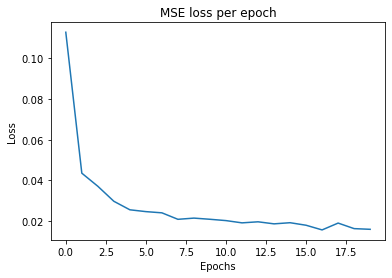

In [72]:
# Checking our loss through the epochs

epoch_loss = model.history.history["loss"]

plt.title("MSE loss per epoch")

plt.plot(range(len(epoch_loss)), epoch_loss)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [73]:
# Converting the test set for prediction
X_test = []

for i in range(timestep, len(test)):
    X_test.append(test_scaled[i-timestep:i, 0])
    
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [74]:
# Shape of the test set 

X_test.shape

(84, 25, 1)

Another way to convert our input train and test data to an acceptable 3D form for the model is using TimeseriesGenerator.

    from keras.preprocessing.sequence import TimeseriesGenerator

    train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=timestep, batch_size=20)

    test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=timestep, batch_size=1)
    
    model.fit_generator(train_gen, epochs=20)
    
    prediction_lstm = model.predict_generator(test_gen)

In [75]:
pred_lstm = model.predict(X_test)

In [76]:
pred_lstm = scaler.inverse_transform(pred_lstm)

In [77]:
len(pred_lstm)

84

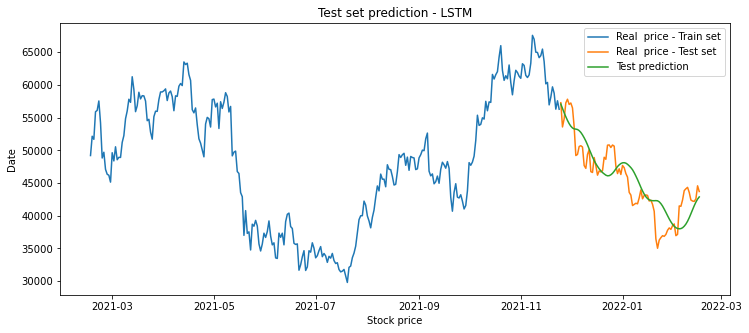

In [80]:
plt.figure(figsize=(12,5))

plt.title("Test set prediction - LSTM")
plt.xlabel("Stock price")
plt.ylabel("Date")

# len(data): 366 - (len(test): 109 - timestep) 
plt.plot(data[:len(data)-(len(test)-timestep)], label = "Real  price - Train set")
plt.plot(test.index[timestep:], test[timestep:], label = "Real  price - Test set")
plt.plot(test.index[timestep:], pred_lstm, label = "Test prediction")
         
plt.legend()

plt.show()

### Evaluation - RMSE, MAPE

In [81]:
rmse_lstm = mean_squared_error(test[timestep:], pred_lstm, squared=False) 

In [82]:
mape_lstm = mean_absolute_percentage_error(test[timestep:], pred_lstm)

In [83]:
print(rmse_lstm)
print(mape_lstm)

3011.551898518567
0.05477035450995295


In [84]:
val_df.loc[2] = ['LSTM', rmse_lstm, mape_lstm]

### Forecast

In [85]:
final_pred_lstm = []

final_batch = np.array(data).reshape(-1,1)
final_batch = scaler.transform(final_batch)
final_batch = final_batch[-timestep:].reshape((1,timestep,1))

for i in range(100):
    
    # predict the next element using our batch
    current_pred = model.predict(final_batch)[0]
    
    # append to the test pred
    final_pred_lstm.append(current_pred)
    
    # update the initial batch with the new element
    final_batch = np.append(final_batch[:,1:,:], [[current_pred]], axis=1)

In [86]:
final_pred_lstm = scaler.inverse_transform(final_pred_lstm)

In [87]:
last_date = data.index[-1]
lstm_dates = pd.date_range(last_date, periods=100).tolist()

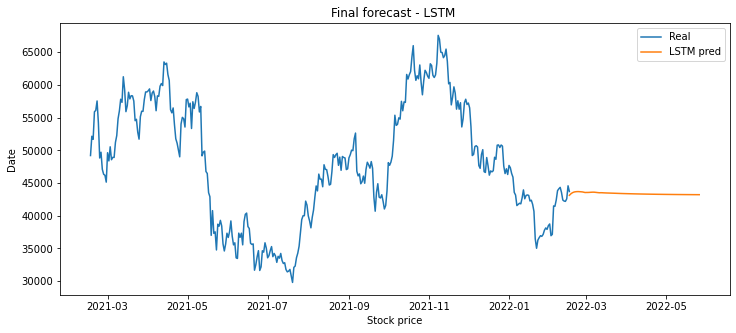

In [88]:
plt.figure(figsize=(12,5))

plt.title("Final forecast - LSTM ")
plt.xlabel("Stock price")
plt.ylabel("Date")

plt.plot(data, label="Real")
plt.plot(lstm_dates, final_pred_lstm, label="LSTM pred")

plt.legend()

plt.show()

# Summary

In [89]:
val_df

,Model,RMSE,MAPE
0,ARIMA,3161.114912,0.053000
1,Prophet,26102.748391,0.479881
2,LSTM,3011.551899,0.054770


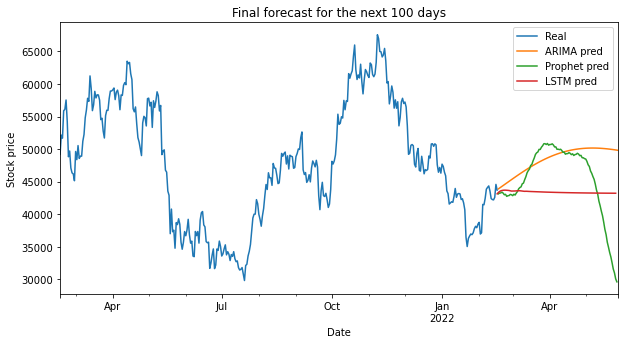

In [90]:
plt.figure(figsize=(10,5))

plt.title("Final forecast for the next 100 days")
plt.xlabel("Date")
plt.ylabel("Stock price")

data.plot(label="Real")
final_pred.plot(label="ARIMA pred")
final_pred_p["Close"].plot(label="Prophet pred")
plt.plot(lstm_dates, final_pred_lstm, label="LSTM pred")

plt.legend()

plt.show()


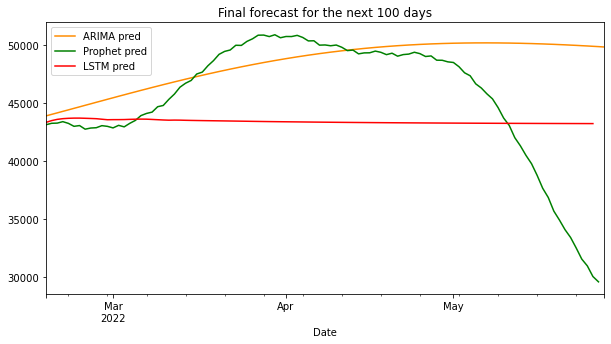

In [91]:
plt.figure(figsize=(10,5))

plt.title("Final forecast for the next 100 days")

final_pred.plot(label="ARIMA pred", color="darkorange")
final_pred_p["Close"].plot(label="Prophet pred", color="g")
plt.plot(lstm_dates, final_pred_lstm, label="LSTM pred", color="r")

plt.legend()

plt.show()